In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings ("ignore")

In [3]:
df = pd.read_csv('hw_daily-temperatures.csv', index_col=['ds'], parse_dates=True)
df.head()

,y
ds,
1987-10-18,10.1
1987-10-19,11.3
1987-10-20,10.4
1987-10-21,10.9
1987-10-22,9.2


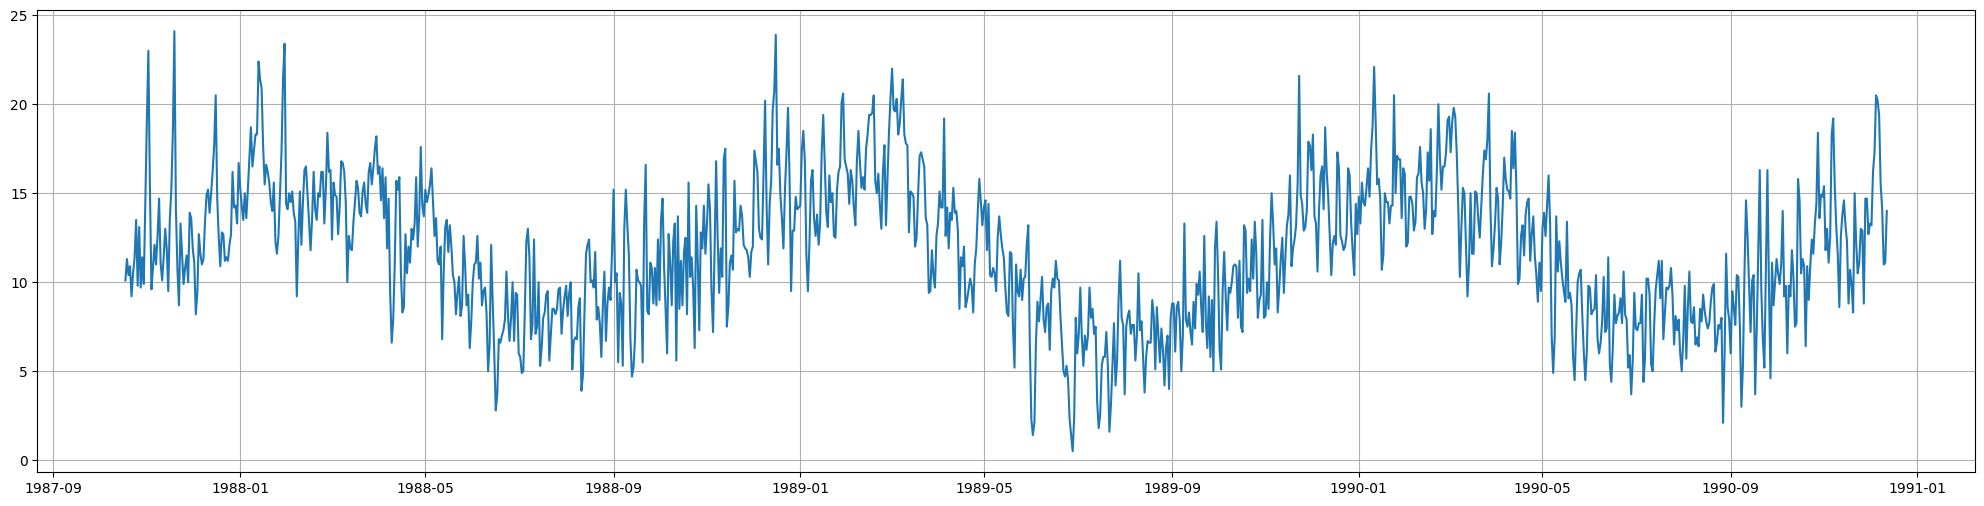

In [4]:
plt.figure(figsize=(25, 6))
plt.plot(df['y'])
plt.grid (True)
plt.show()

11:50:05 - cmdstanpy - INFO - Chain [1] start processing
11:50:05 - cmdstanpy - INFO - Chain [1] done processing


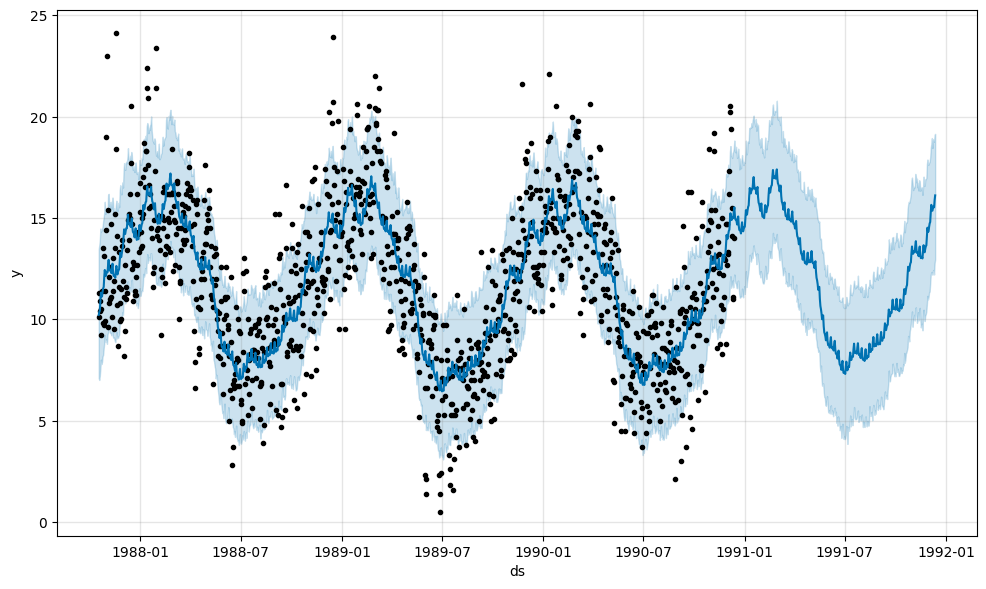

In [6]:
from prophet import Prophet

df = pd.read_csv('hw_daily-temperatures.csv')

m = Prophet()
m.fit(df)

future = m.make_future_dataframe(periods=365)

fcst = m.predict(future)
fig = m.plot(fcst)

In [16]:
from sklearn.metrics import mean_absolute_percentage_error
from itertools import product
from prophet.diagnostics import cross_validation
from prophet. diagnostics import performance_metrics

param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# сгенерируем список из словарей параметров
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

mapes = [] # здесь будем хранить результаты расчёта МАРЕ на кроссалидации

# для каждого набора параметров просчитаем кроссвалидацию
for params in all_params:
    m = Prophet(**params).fit(df) # Fit model with given params
    # функция cross_validation создаёт нам датафрейм с данными о предсказаниях на различных сплитах 
    # это будет тот самый так называемый simulated historical forecasts на сплитах, которые мы укажем
    df_cv = cross_validation(m,
                             initial='365 days', # длина первого сплита кроссвалидации (1 год)
                             period='30 days', # шаг удлиннения сплита (1 месяц)
                             horizon='30 days' # Валидационный период для прогнозирования (1 месяц)
                            )
    # на этом датафрейме дальше можно посчитать значения различных метрик
    df_p = performance_metrics(df_cv)
    
    # будем оценивать по МАРЕ
    mapes.append(df_p['mape'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

11:56:45 - cmdstanpy - INFO - Chain [1] start processing
11:56:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:56:46 - cmdstanpy - INFO - Chain [1] start processing
11:56:46 - cmdstanpy - INFO - Chain [1] done processing
11:56:46 - cmdstanpy - INFO - Chain [1] start processing
11:56:46 - cmdstanpy - INFO - Chain [1] done processing
11:56:46 - cmdstanpy - INFO - Chain [1] start processing
11:56:46 - cmdstanpy - INFO - Chain [1] done processing
11:56:46 - cmdstanpy - INFO - Chain [1] start processing
11:56:46 - cmdstanpy - INFO - Chain [1] done processing
11:56:46 - cmdstanpy - INFO - Chain [1] start processing
11:56:46 - cmdstanpy - INFO - Chain [1] done processing
11:56:46 - cmdstanpy - INFO - Chain [1] start processing
11:56:46 - cmdstanpy - INFO - Chain [1] done processing
11:56:46 - cmdstanpy - INFO - Chain [1] start processing
11:56:46 - cmdstanpy - INFO - Chain [1] done pro

In [17]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,mape
0,0.01,0.01,0.277055
1,0.01,0.10,0.242820
2,0.01,1.00,0.244698
3,0.01,10.00,0.246269
4,0.10,0.01,0.257909
5,0.10,0.10,0.227789
6,0.10,1.00,0.227889
7,0.10,10.00,0.228100
8,0.50,0.01,0.245296
9,0.50,0.10,0.216825


In [18]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}


11:57:39 - cmdstanpy - INFO - Chain [1] start processing
11:57:39 - cmdstanpy - INFO - Chain [1] done processing


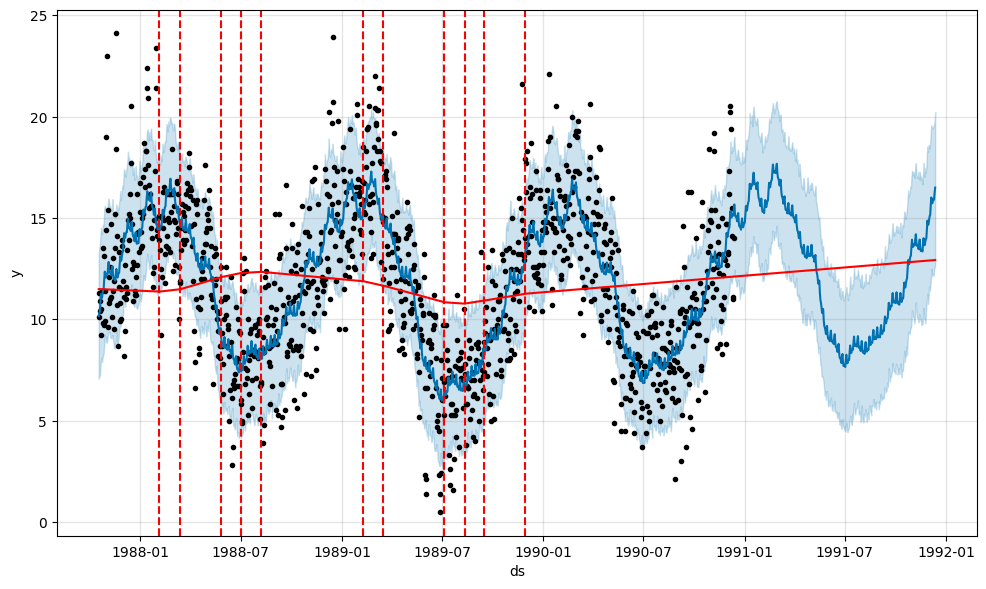

In [19]:
from prophet.plot import add_changepoints_to_plot

m = Prophet(**best_params)
m.fit(df)

future = m.make_future_dataframe(periods=365)

fcst = m.predict(future)
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)